# Load necessary packages

In [ ]:
import pandas as pd
import numpy as np

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates

import matplotlib.font_manager as font_manager
mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'SF Mono'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

import tensorflow as tf

In [ ]:
! pip install 'git+git://github.com/HR/github-clone#egg=ghclone' &> /dev/null

! ghclone https://github.com/timovijn/ElectricityPriceForecasting/tree/master/LSTM

Cloning into 'LSTM'...
done.


In [ ]:
features = pd.read_pickle(f"./LSTM/features.pkl")

ID3 = pd.DataFrame()

ID3['ID3'] = features['ID3']

In [ ]:
features.head(5)

,ID3,VOL,MCP,LOAD,LOAD_F,LOAD_FE,ID3 (-4),ID3 (-5),ID3 (-6),ID3 (-7),ID3 (-8),ID3 (-9),ID3 (-10),ID3 (-11),ID3 (-12),ID3 (-13),ID3 (-14),ID3 (-15),ID3 (-16),ID3 (-17),ID3 (-18),ID3 (-19),ID3 (-20),ID3 (-21),ID3 (-22),ID3 (-23),ID3 (-24),ID3 (-25),ID3 (-26),ID3 (-27),ID3 (-28),ID3 (-29),ID3 (-30),ID3 (-31),ID3 (-32),ID3 (-33),ID3 (-34),ID3 (-35),ID3 (-36),ID3 (-37),...,VOL (-22),VOL (-23),VOL (-24),Gen. forecast,Gen. (s) forecast,Gen. (w_off) forecast,Gen. (w_on) forecast,DOW,DOW 0,DOW 1,DOW 2,DOW 3,DOW 4,DOW 5,DOW 6,HOD,HOD 0,HOD 1,HOD 2,HOD 3,HOD 4,HOD 5,HOD 6,HOD 7,HOD 8,HOD 9,HOD 10,HOD 11,HOD 12,HOD 13,HOD 14,HOD 15,HOD 16,HOD 17,HOD 18,HOD 19,HOD 20,HOD 21,HOD 22,HOD 23
2015-01-01 05:00:00+00:00,27.500000,29.0,27.41,8291.75,9994.25,1702.50,25.625000,29.100000,26.357143,26.073529,27.538462,31.480519,36.581111,35.371102,35.561247,26.881944,34.906250,36.000000,23.372727,23.372727,29.951386,29.862160,28.795380,23.342037,28.928153,39.433384,37.986468,27.000000,41.867257,51.000000,51.590164,51.900000,41.067436,40.806625,40.597342,43.215488,41.725543,53.263736,54.308642,59.623967,...,231.0,624.0,669.3,11869.0,0.0,57.50,515.50,3,0,0,0,1,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,26.780822,28.0,27.52,8638.25,11882.00,3243.75,29.100000,26.357143,26.073529,27.538462,31.480519,36.581111,35.371102,35.561247,26.881944,34.906250,36.000000,23.372727,23.372727,29.951386,29.862160,28.795380,23.342037,28.928153,39.433384,37.986468,27.000000,41.867257,51.000000,51.590164,51.900000,41.067436,40.806625,40.597342,43.215488,41.725543,53.263736,54.308642,59.623967,53.237458,...,624.0,669.3,722.9,14495.0,0.0,61.50,551.00,3,0,0,0,1,0,0,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 07:00:00+00:00,25.852273,65.0,26.80,8927.25,13240.00,4312.75,26.357143,26.073529,27.538462,31.480519,36.581111,35.371102,35.561247,26.881944,34.906250,36.000000,23.372727,23.372727,29.951386,29.862160,28.795380,23.342037,28.928153,39.433384,37.986468,27.000000,41.867257,51.000000,51.590164,51.900000,41.067436,40.806625,40.597342,43.215488,41.725543,53.263736,54.308642,59.623967,53.237458,55.302469,...,669.3,722.9,655.2,16740.0,0.0,65.75,592.25,3,0,0,0,1,0,0,0,7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 08:00:00+00:00,24.400000,18.0,28.48,9312.50,13817.25,4504.75,26.073529,27.538462,31.480519,36.581111,35.371102,35.561247,26.881944,34.906250,36.000000,23.372727,23.372727,29.951386,29.862160,28.795380,23.342037,28.928153,39.433384,37.986468,27.000000,41.867257,51.000000,51.590164,51.900000,41.067436,40.806625,40.597342,43.215488,41.725543,53.263736,54.308642,59.623967,53.237458,55.302469,55.146552,...,722.9,655.2,0.0,16907.0,31.0,70.50,635.50,3,0,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,25.625000,15.0,27.71,9933.25,14072.50,4139.25,27.538462,31.480519,36.581111,35.371102,35.561247,26.881944,34.906250,36.000000,23.372727,23.372727,29.951386,29.862160,28.795380,23.342037,28.928153,39.433384,37.986468,27.000000,41.867257,51.000000,51.590164,51.900000,41.067436,40.806625,40.597342,43.215488,41.725543,53.263736,54.308642,59.623967,53.237458,55.302469,55.146552,54.536232,...,655.2,0.0,21.0,17313.0,97.0,72.75,654.00,3,0,0,0,1,0,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
features.tail(5)

,ID3,VOL,MCP,LOAD,LOAD_F,LOAD_FE,ID3 (-4),ID3 (-5),ID3 (-6),ID3 (-7),ID3 (-8),ID3 (-9),ID3 (-10),ID3 (-11),ID3 (-12),ID3 (-13),ID3 (-14),ID3 (-15),ID3 (-16),ID3 (-17),ID3 (-18),ID3 (-19),ID3 (-20),ID3 (-21),ID3 (-22),ID3 (-23),ID3 (-24),ID3 (-25),ID3 (-26),ID3 (-27),ID3 (-28),ID3 (-29),ID3 (-30),ID3 (-31),ID3 (-32),ID3 (-33),ID3 (-34),ID3 (-35),ID3 (-36),ID3 (-37),...,VOL (-22),VOL (-23),VOL (-24),Gen. forecast,Gen. (s) forecast,Gen. (w_off) forecast,Gen. (w_on) forecast,DOW,DOW 0,DOW 1,DOW 2,DOW 3,DOW 4,DOW 5,DOW 6,HOD,HOD 0,HOD 1,HOD 2,HOD 3,HOD 4,HOD 5,HOD 6,HOD 7,HOD 8,HOD 9,HOD 10,HOD 11,HOD 12,HOD 13,HOD 14,HOD 15,HOD 16,HOD 17,HOD 18,HOD 19,HOD 20,HOD 21,HOD 22,HOD 23
2018-12-21 23:00:00+00:00,50.911996,499.5,50.63,11756.25,12950.00,1193.75,53.277543,53.479330,54.977402,57.227163,57.961460,58.304843,57.755109,57.734450,57.030576,55.532917,53.950100,53.804547,58.985019,64.848069,69.180784,70.461262,67.409818,61.838669,64.747692,59.653026,54.260255,53.110401,42.290105,40.798089,40.131086,45.098035,43.113613,45.515599,49.957831,51.971971,53.567745,57.140200,54.067251,54.275900,...,68.0,133.9,81.3,12458.0,0.0,703.25,1957.75,4,0,0,0,0,1,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-22 00:00:00+00:00,53.554378,309.1,53.07,11164.25,12318.00,1153.75,53.479330,54.977402,57.227163,57.961460,58.304843,57.755109,57.734450,57.030576,55.532917,53.950100,53.804547,58.985019,64.848069,69.180784,70.461262,67.409818,61.838669,64.747692,59.653026,54.260255,53.110401,42.290105,40.798089,40.131086,45.098035,43.113613,45.515599,49.957831,51.971971,53.567745,57.140200,54.067251,54.275900,52.888528,...,133.9,81.3,88.0,11972.0,0.0,714.00,1939.50,5,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-22 01:00:00+00:00,53.716854,438.8,48.50,10796.75,11741.50,944.75,54.977402,57.227163,57.961460,58.304843,57.755109,57.734450,57.030576,55.532917,53.950100,53.804547,58.985019,64.848069,69.180784,70.461262,67.409818,61.838669,64.747692,59.653026,54.260255,53.110401,42.290105,40.798089,40.131086,45.098035,43.113613,45.515599,49.957831,51.971971,53.567745,57.140200,54.067251,54.275900,52.888528,55.932461,...,81.3,88.0,88.3,11679.0,0.0,734.25,2051.00,5,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-22 02:00:00+00:00,52.950763,294.6,46.54,10626.25,11420.75,794.50,57.227163,57.961460,58.304843,57.755109,57.734450,57.030576,55.532917,53.950100,53.804547,58.985019,64.848069,69.180784,70.461262,67.409818,61.838669,64.747692,59.653026,54.260255,53.110401,42.290105,40.798089,40.131086,45.098035,43.113613,45.515599,49.957831,51.971971,53.567745,57.140200,54.067251,54.275900,52.888528,55.932461,57.428586,...,88.0,88.3,29.0,11264.0,0.0,730.50,2147.25,5,0,0,0,0,0,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-12-22 03:00:00+00:00,53.277543,439.2,39.50,10685.50,11313.00,627.50,57.961460,58.304843,57.755109,57.734450,57.030576,55.532917,53.950100,53.804547,58.985019,64.848069,69.180784,70.461262,67.409818,61.838669,64.747692,59.653026,54.260255,53.110401,42.290105,40.798089,40.131086,45.098035,43.113613,45.515599,49.957831,51.971971,53.567745,57.140200,54.067251,54.275900,52.888528,55.932461,57.428586,59.725511,...,88.3,29.0,157.8,11255.0,0.0,723.50,2115.75,5,0,0,0,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Alternative (2) create train/test data

In [ ]:
# def ts_train_test(ID3, time_steps, for_periods):

#     # Create training and test sets
#     mask = (ID3.index.year < 2018)
#     ts_train = ID3.loc[mask]['ID3'].values
#     ts_train = ts_train.reshape(1, -1).transpose()

#     mask = (ID3.index.year == 2018)
#     ts_test = ID3.loc[mask]['ID3'].values
#     ts_test = ts_test.reshape(1, -1).transpose()

#     # ts_train = ID3[:'2018'].iloc['ID3'].values
#     # ts_test  = ID3['2019':].iloc['ID3'].values

#     # Scale the data
#     from sklearn.preprocessing import MinMaxScaler
#     sc = MinMaxScaler(feature_range=(0,1))
#     ts_train_unscaled = ts_train
#     ts_train = sc.fit_transform(ts_train)

#     # Create training data of s samples and t time steps
#     X_train = []
#     y_train = []
#     y_train_stacked = []
    
#     for i in range(time_steps, len(ts_train)-1): 
#         X_train.append(ts_train[i-time_steps:i,0])
#         y_train.append(ts_train[i:i+for_periods,0])
#     X_train, y_train = np.array(X_train), np.array(y_train)

#     # Reshape X_train for efficient modelling
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#     # Prepare to create X_test
#     inputs = pd.concat((ID3['ID3'][:'2018'], ID3['ID3']['2019':]),axis=0).values
#     inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
#     inputs = inputs.reshape(-1,1)
#     inputs  = sc.transform(inputs)

#     X_test = []
#     for i in range(time_steps, len(ts_test)+time_steps-for_periods):
#         X_test.append(inputs[i-time_steps:i,0])
        
#     X_test = np.array(X_test)
#     X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#     return X_train, y_train , X_test, sc

# ##########################################################################
# X_train, y_train, X_test, sc = ts_train_test(ID3, 5, 2)
# ##########################################################################

# X_train.shape[0], X_train.shape[1]

# print(X_train)

# Create train/test data

In [ ]:
time_steps = 24
for_periods = 1
lag = 23                 # Extra lag

# Create training and test sets
mask = (ID3.index.year < 2018)
train_mat = ID3.loc[mask]['ID3']
ts_train = np.array(ID3.loc[mask]['ID3'])
ts_train = ts_train.reshape(1, -1).transpose()

mask = (ID3.index.year == 2018)
test_mat = ID3.loc[mask]['ID3']
ts_test = np.array(ID3.loc[mask]['ID3'])
ts_test = ts_test.reshape(1, -1).transpose()

# # Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

# Fit scaler on train and transform train

ts_train_unscaled = ts_train
ts_train = sc.fit_transform(ts_train)

# Transform test with train-fitted scaler

ts_test_unscaled = ts_test
ts_test = sc.transform(ts_test)

# Create training data of s samples and t time steps
X_train = []
y_train = []

for i in range(time_steps+lag, len(ts_train)):
    X_train.append(ts_train[i-lag-time_steps:i-lag,0])
    y_train.append(ts_train[i:i+for_periods,0])

X_train = np.array(X_train)
y_train = np.array([item for sublist in y_train for item in sublist])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
y_test = []
y_test_unscaled = []

for i in range(time_steps+lag, len(ts_test)):
    X_test.append(ts_test[i-lag-time_steps:i-lag,0])
    y_test.append(ts_test[i:i+for_periods,0])
    y_test_unscaled.append(ts_test_unscaled[i:i+for_periods,0])

X_test = np.array(X_test)
y_test = np.array([item for sublist in y_test for item in sublist])
y_test_unscaled = np.array([item for sublist in y_test_unscaled for item in sublist])
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(train_mat), print(), print(train_mat.shape);

2015-01-01 05:00:00+00:00    27.500000
2015-01-01 06:00:00+00:00    26.780822
2015-01-01 07:00:00+00:00    25.852273
2015-01-01 08:00:00+00:00    24.400000
2015-01-01 09:00:00+00:00    25.625000
                               ...    
2017-12-31 19:00:00+00:00    80.726384
2017-12-31 20:00:00+00:00    67.293939
2017-12-31 21:00:00+00:00    24.224867
2017-12-31 22:00:00+00:00    18.912550
2017-12-31 23:00:00+00:00    16.199165
Name: ID3, Length: 25385, dtype: float64

(25385,)


In [ ]:
print(test_mat), print(), print(test_mat.shape);

2018-01-01 00:00:00+00:00    14.586875
2018-01-01 01:00:00+00:00    12.990924
2018-01-01 02:00:00+00:00    22.150235
2018-01-01 03:00:00+00:00    21.917514
2018-01-01 04:00:00+00:00    21.621781
                               ...    
2018-12-21 23:00:00+00:00    50.911996
2018-12-22 00:00:00+00:00    53.554378
2018-12-22 01:00:00+00:00    53.716854
2018-12-22 02:00:00+00:00    52.950763
2018-12-22 03:00:00+00:00    53.277543
Name: ID3, Length: 8460, dtype: float64

(8460,)


# Alternative create train/test

In [ ]:
# inputs = features[['ID3']]
# outputs = features[['ID3']]

# inputs_train = inputs[inputs.index.year < 2018]
# outputs_train = outputs[outputs.index.year < 2018]

# inputs_test = inputs[inputs.index.year == 2018]
# outputs_test = outputs[outputs.index.year == 2018]

# # Scale inputs
# scaler = MinMaxScaler()

# inputs_train = pd.DataFrame(scaler.fit_transform(inputs_train), columns = inputs_train.columns)
# inputs_test = pd.DataFrame(scaler.transform(inputs_test), columns = inputs_test.columns)

# # Scale outputs
# sc = MinMaxScaler()

# sc.fit_transform(outputs_train)

# outputs_train = pd.DataFrame(sc.fit_transform(outputs_train), columns = outputs_train.columns)
# outputs_test = pd.DataFrame(sc.transform(outputs_test), columns = outputs_test.columns)

# time_steps = 6
# for_periods = 1
# lag = 4

# # X_train and y_train

# X_train = []
# y_train = []

# for i in range(0, len(outputs_train)-time_steps-lag+1):
#     for ii in range(0, time_steps):
#         X_train.extend(inputs_train.iloc[i+ii].to_numpy())
#     y_train.extend(outputs_train.iloc[i+time_steps+lag-1].to_numpy())

# X_train, y_train = np.array(X_train), np.array(y_train)

# X_train = X_train.reshape(y_train.shape[0], time_steps, inputs.shape[1])

# # X_test and y_test

# X_test = []
# y_test = []

# for i in range(0, len(outputs_test)-time_steps-lag+1):
#     for ii in range(0, time_steps):
#         X_test.extend(inputs_test.iloc[i+ii].to_numpy())
#     y_test.extend(outputs_test.iloc[i+time_steps+lag-1].to_numpy())

# X_test, y_test = np.array(X_test), np.array(y_test)

# sc = MinMaxScaler(feature_range=(0,1))

# X_test = X_test.reshape(y_test.shape[0], time_steps, inputs.shape[1])

# Create see data

In [ ]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
y_test_see = pd.DataFrame(y_test)
y_test_unscaled_see = pd.DataFrame(y_test_unscaled)

# See train data

In [ ]:
print(), print(colored(f'There are {X_train.shape[0]} samples in the training data', 'green'));

print(), print(X_train.shape), print(), print(X_train_see);
print(), print(y_train.shape), print(), print(y_train_see);


There are 25338 samples in the training data

(25338, 24, 1)

             0         1         2   ...        21        22        23
0      0.111491  0.109574  0.107099  ...  0.100408  0.115298  0.143301
1      0.109574  0.107099  0.103228  ...  0.115298  0.143301  0.139444
2      0.107099  0.103228  0.106493  ...  0.143301  0.139444  0.110158
3      0.103228  0.106493  0.115756  ...  0.139444  0.110158  0.149788
4      0.106493  0.115756  0.108445  ...  0.110158  0.149788  0.174132
...         ...       ...       ...  ...       ...       ...       ...
25333  0.143479  0.129030  0.117914  ...  0.119580  0.125152  0.134952
25334  0.129030  0.117914  0.110427  ...  0.125152  0.134952  0.141761
25335  0.117914  0.110427  0.112221  ...  0.134952  0.141761  0.128252
25336  0.110427  0.112221  0.113326  ...  0.141761  0.128252  0.119170
25337  0.112221  0.113326  0.119709  ...  0.128252  0.119170  0.121764

[25338 rows x 24 columns]

(25338,)

              0
0      0.138733
1      0.146856

# See test data

In [ ]:
print(), print(colored(f'There are {X_test.shape[0]} samples in the test data', 'green')), print();

print(), print(X_test.shape), print(), print(X_test_see);
print(), print(y_test_unscaled.shape), print(), print(y_test_unscaled_see);


There are 8413 samples in the test data


(8413, 24, 1)

            0         1         2   ...        21        22        23
0     0.077070  0.072816  0.097231  ...  0.094089  0.094840  0.093697
1     0.072816  0.097231  0.096611  ...  0.094840  0.093697  0.097159
2     0.097231  0.096611  0.095822  ...  0.093697  0.097159  0.089835
3     0.096611  0.095822  0.097771  ...  0.097159  0.089835  0.087033
4     0.095822  0.097771  0.099687  ...  0.089835  0.087033  0.088639
...        ...       ...       ...  ...       ...       ...       ...
8408  0.193950  0.192317  0.184327  ...  0.165389  0.158812  0.151674
8409  0.192317  0.184327  0.191436  ...  0.158812  0.151674  0.142702
8410  0.184327  0.191436  0.198999  ...  0.151674  0.142702  0.138333
8411  0.191436  0.198999  0.209214  ...  0.142702  0.138333  0.137107
8412  0.198999  0.209214  0.215401  ...  0.138333  0.137107  0.136315

[8413 rows x 24 columns]

(8413,)

              0
0     30.413644
1     30.863618
2     31.229744
3 

In [ ]:
import keras
import keras.backend as K

class Dropout(keras.layers.Dropout):
  """Applies Dropout to the input.
  The Dropout layer randomly sets input units to 0 with a frequency of `rate`
  at each step during training time, which helps prevent overfitting.
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over
  all inputs is unchanged.
  Note that the Dropout layer only applies when `training` is set to True
  such that no values are dropped during inference. When using `model.fit`,
  `training` will be appropriately set to True automatically, and in other
  contexts, you can set the kwarg explicitly to True when calling the layer.
  (This is in contrast to setting `trainable=False` for a Dropout layer.
  `trainable` does not affect the layer's behavior, as Dropout does
  not have any variables/weights that can be frozen during training.)
  >>> tf.random.set_seed(0)
  >>> layer = tf.keras.layers.Dropout(.2, input_shape=(2,))
  >>> data = np.arange(10).reshape(5, 2).astype(np.float32)
  >>> print(data)
  [[0. 1.]
   [2. 3.]
   [4. 5.]
   [6. 7.]
   [8. 9.]]
  >>> outputs = layer(data, training=True)
  >>> print(outputs)
  tf.Tensor(
  [[ 0.    1.25]
   [ 2.5   3.75]
   [ 5.    6.25]
   [ 7.5   8.75]
   [10.    0.  ]], shape=(5, 2), dtype=float32)
  Args:
    rate: Float between 0 and 1. Fraction of the input units to drop.
    noise_shape: 1D integer tensor representing the shape of the
      binary dropout mask that will be multiplied with the input.
      For instance, if your inputs have shape
      `(batch_size, timesteps, features)` and
      you want the dropout mask to be the same for all timesteps,
      you can use `noise_shape=(batch_size, 1, features)`.
    seed: A Python integer to use as random seed.
  Call arguments:
    inputs: Input tensor (of any rank).
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (doing nothing).
  """
  
  def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
    super(Dropout, self).__init__(rate, noise_shape=None, seed=None, **kwargs)
    self.training = training

  def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)

        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        if not training:
            return K.in_train_phase(dropped_inputs, inputs, training=self.training)
        return K.in_train_phase(dropped_inputs, inputs, training=training)
    return inputs

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model_lstm.add(LSTM(units = 100, return_sequences = True))
    model_lstm.add(LSTM(units = 50, return_sequences = False))
    
    model_lstm.add(Dense(units = 1, activation='linear'))

    optimizer = Adam(clipvalue=0.5)
    # model_lstm.compile(loss = 'mse', optimizer=optimizer)

    # Compiling
    model_lstm.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    model_lstm.fit(X_train,y_train,epochs=1,batch_size=32, verbose=1)

    LSTM_prediction = model_lstm.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    # self.model = model_lstm

    return model_lstm, LSTM_prediction

def LSTM_model2(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam
    
    model_lstm = Sequential()
    
    model_lstm.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],1), activation='tanh'))
    
    model_lstm.add(Dropout(0.2, training=True))
    
    model_lstm.add(LSTM(units = 100, return_sequences = False))

    model_lstm.add(Dropout(0.2, training=True))
    
    # model_lstm.add(LSTM(units = 50, return_sequences = False))
    
    model_lstm.add(Dense(units = 1, activation='relu'))

    optimizer = Adam(clipvalue=0.5)
    # model_lstm.compile(loss = 'mse', optimizer=optimizer)

    # Compiling
    model_lstm.compile(optimizer=optimizer,loss='mean_squared_error')
    # Fitting to the training set
    model_lstm.fit(X_train,y_train,epochs=5,batch_size=32, verbose=1)

    LSTM_prediction = model_lstm.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    # self.model = model_lstm

    return model_lstm, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model2(X_train, y_train, X_test, sc)

Epoch 1/5
792/792 [==============================] - 8s 5ms/step - loss: 0.0019
Epoch 2/5
792/792 [==============================] - 4s 5ms/step - loss: 0.0014
Epoch 3/5
792/792 [==============================] - 4s 6ms/step - loss: 0.0014
Epoch 4/5
792/792 [==============================] - 4s 5ms/step - loss: 0.0014
Epoch 5/5
792/792 [==============================] - 4s 5ms/step - loss: 0.0014


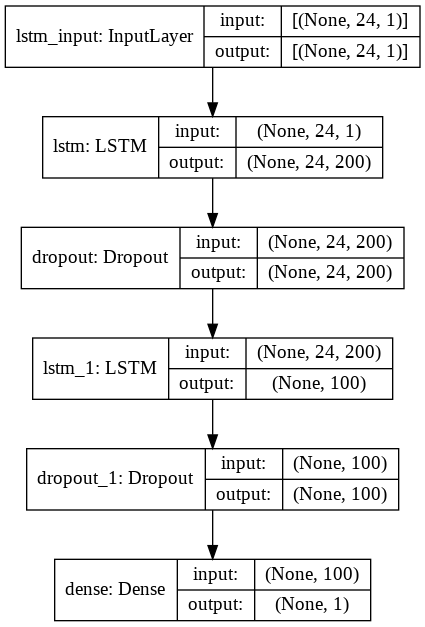

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(my_LSTM_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

evaluation = pd.DataFrame()
evaluation['Actual'] = y_test_unscaled
evaluation['Predicted'] = LSTM_prediction

fig1 = go.Scatter(      x = evaluation.index,
                        y = evaluation['Actual'],
                        name = 'Actual'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

fig2 = go.Scatter(      x = evaluation.index,
                        y = evaluation['Predicted'],
                        name = 'Predicted'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

data = [fig1, fig2]

fig = go.Figure(data=data)

fig.show()

In [ ]:
# def actual_pred_plot(preds):

#     actual_pred = pd.DataFrame()

#     mask = (ID3.index.year == 2018)
#     actual_pred['Actual'] = ID3.loc[mask]['ID3'][0:len(preds)]
#     actual_pred['Predicted'] = preds[:, 0]

#     from keras.metrics import MeanSquaredError
#     m = MeanSquaredError()
#     actual_pred['Actual'] = actual_pred['Actual']
#     actual_pred['Predicted'] = actual_pred['Predicted']
#     m.update_state(np.array(actual_pred['Actual']), np.array(actual_pred['Predicted']))
    
#     return (m.result().numpy(), actual_pred)

# m, prediction = actual_pred_plot(LSTM_prediction)

In [ ]:
# X = features.drop(labels=['ID3', 'VOL', 'LOAD_F', 'LOAD_FE'], axis=1)
# y = features['ID3']

# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size = 0.3,
#     random_state = 0,
#     shuffle = True)

# X_train.shape, X_test.shape

In [ ]:
# X_train_unscaled = X_train
# X_test_unscaled = X_test

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train_unscaled)

# X_test = scaler.transform(X_test_unscaled)

In [ ]:
# def MLP_model(X_train, y_train, X_test):
#     # create a model
#     from keras.models import Sequential
#     from keras.layers import Dense
#     from keras.optimizers import SGD, Adam
    
#     model_MLP = Sequential()
#     model_MLP.add(Dense(200, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
#     model_MLP.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#     model_MLP.add(Dense(1))

#     optimizer = Adam(clipvalue=0.5)
#     # model_lstm.compile(loss = 'mse', optimizer=optimizer)

#     # Compiling
#     model_MLP.compile(optimizer=optimizer,loss='mean_squared_error')
#     # Fitting to the training set
#     model_MLP.fit(X_train, y_train, epochs = 50, batch_size = 16, verbose = 5)

#     prediction = model_MLP.predict(X_test)
#     # prediction = sc.inverse_transform(prediction)

#     # self.model = model_lstm

#     return model_MLP, prediction

# model, prediction = MLP_model(X_train, y_train, X_test)

In [ ]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# #Step1. Define the model
# model = Sequential()
# model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (X_train.shape[1],)))
# model.add(Dense(8, activation = 'relu', kernel_initializer = 'he_normal'))
# model.add(Dense(1))
# #Step2. Compile the model
# model.compile(optimizer = 'adam', loss = 'mse', metrics = 'mae')
# #Step3. Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,batch_size=64, verbose=5)
# #Step4.1 Evaluate the model
# loss, mae = model.evaluate(X_test, y_test)
# #Step4.2 Plot the learning curve
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
# plt.show()

# prediction = model.predict(X_test)

In [ ]:
# actual_pred = pd.DataFrame()

# actual_pred['Actual'] = features['ID3'][0:len(prediction)]
# actual_pred['Predicted'] = prediction[:, 0]

# from keras.metrics import MeanSquaredError
# m = MeanSquaredError()
# actual_pred['Actual'] = actual_pred['Actual'].astype(int)
# actual_pred['Predicted'] = actual_pred['Predicted'].astype(int)
# m.update_state(np.array(actual_pred['Actual']), np.array(actual_pred['Predicted']))

# x, y = actual_pred.index, actual_pred['Actual']

# fig, ax = plt.subplots(figsize = (5 ,5))
# ax.plot(x, y)

# plt.xticks(rotation = 90)

# x, y = actual_pred.index, actual_pred['Predicted']

# fig, ax = plt.subplots(figsize = (5 ,5))
# ax.plot(x, y)

# plt.xticks(rotation = 90);

# m

In [ ]:
# # ####################################################################################################
# # # Pre

# actual_pred = prediction

# # actual_pred = pd.DataFrame()

# # actual_pred['Actual'] = features['ID3'][0:len(prediction)]
# # actual_pred['Predicted'] = prediction[:, 0]

# # ####################################################################################################
# # # Plot 1

# # fig, ax = plt.subplots(figsize = (10 ,5))

# # x, y = actual_pred[0:100].index, actual_pred[0:100]['Actual']

# # ax.plot(x, y, linewidth=0.5)

# # ####################################################################################################
# # # Plot 2

# # x, y = actual_pred[0:100].index, actual_pred[0:100]['Predicted']

# # ax.plot(x, y, alpha = 0.5)

# # plt.xticks(rotation = 90);

# import plotly.express as px
# import plotly.graph_objects as go

# actual = pd.DataFrame(['ID3'])
# predicted = pd.DataFrame(['ID3'])

# actual = pd.DataFrame(actual_pred['Actual'].values)
# actual['Type'] = 'Actual'
# predicted = pd.DataFrame(actual_pred['Predicted'].values)
# predicted['Type'] = 'Predicted'

# evaluation = pd.DataFrame(pd.concat([actual, 
#                         predicted],
#                         axis=0))

# fig1 = go.Scatter(      x = actual_pred.index,
#                     y = actual_pred['Actual'],
#                   name = 'Actual'
#                     # color = evaluation['Type'],
#                     # title = "Log of Appliance Energy Consumption in Wh vs Time"
#                     )

# fig2 = go.Scatter(      x = actual_pred.index,
#                     y = actual_pred['Predicted'],
#                   name = 'Predicted'
#                     # color = evaluation['Type'],
#                     # title = "Log of Appliance Energy Consumption in Wh vs Time"
#                     )

# data = [fig1, fig2]

# fig = go.Figure(data=data)

# fig.show()

In [ ]:
n_experiments = 50

test_uncertainty_df = pd.DataFrame()

for i in range(1, n_experiments + 1):
  experiment_prediction = my_LSTM_model.predict(X_test)
  test_uncertainty_df['ID3_{}'.format(i)] = np.concatenate(sc.inverse_transform(experiment_prediction), axis = 0)
  
  if i % 1 == 0:
    print(f'Experiment: {i}/{n_experiments}')

# log_energy_consumption_df = test_uncertainty_df.filter(like='ID3', axis=1)
test_uncertainty_df['ID3_mean'] = test_uncertainty_df.mean(axis=1)
test_uncertainty_df['ID3_std'] = test_uncertainty_df.std(axis=1)

test_uncertainty_df = test_uncertainty_df[['ID3_mean', 'ID3_std']]

test_uncertainty_df['lower_bound'] = test_uncertainty_df['ID3_mean'] - 3*test_uncertainty_df['ID3_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['ID3_mean'] + 3*test_uncertainty_df['ID3_std']

print(), print(test_uncertainty_df);

Experiment: 1/50
Experiment: 2/50
Experiment: 3/50
Experiment: 4/50
Experiment: 5/50
Experiment: 6/50
Experiment: 7/50
Experiment: 8/50
Experiment: 9/50
Experiment: 10/50
Experiment: 11/50
Experiment: 12/50
Experiment: 13/50
Experiment: 14/50
Experiment: 15/50
Experiment: 16/50
Experiment: 17/50
Experiment: 18/50
Experiment: 19/50
Experiment: 20/50
Experiment: 21/50
Experiment: 22/50
Experiment: 23/50
Experiment: 24/50
Experiment: 25/50
Experiment: 26/50
Experiment: 27/50
Experiment: 28/50
Experiment: 29/50
Experiment: 30/50
Experiment: 31/50
Experiment: 32/50
Experiment: 33/50
Experiment: 34/50
Experiment: 35/50
Experiment: 36/50
Experiment: 37/50
Experiment: 38/50
Experiment: 39/50
Experiment: 40/50
Experiment: 41/50
Experiment: 42/50
Experiment: 43/50
Experiment: 44/50
Experiment: 45/50
Experiment: 46/50
Experiment: 47/50
Experiment: 48/50
Experiment: 49/50
Experiment: 50/50

       ID3_mean   ID3_std  lower_bound  upper_bound
0     29.977320  1.376580    25.847580    34.107059
1   

In [ ]:
import plotly.graph_objects as go

upper_trace = go.Scatter(
    y=test_uncertainty_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Confidence Bound'
    )

lower_trace = go.Scatter(
    y=test_uncertainty_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.5)',
    name='99% Lower Confidence Bound'
    )

real_trace = go.Scatter(
    y=evaluation['Actual'],
    mode='lines',
    fill=None,
    name='Real Values'
    )

mean_trace = go.Scatter(
    y=test_uncertainty_df['ID3_mean'],
    mode='lines',
    fill=None,
    name='Mean Values'
    )

data = [upper_trace, lower_trace, mean_trace, real_trace]

fig = go.Figure(data=data)
fig.update_layout(title='Uncertainty Quantification for ID3 Test Data',
                   xaxis_title='Time',
                   yaxis_title='ID3 (€)')

fig.layout.font.family = 'SF Mono'

fig.show()

In [ ]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds
bounds_df['lower_bound'] = test_uncertainty_df['lower_bound']
bounds_df['prediction'] = test_uncertainty_df['ID3_mean']
bounds_df['real_value'] = evaluation['Actual']
bounds_df['upper_bound'] = test_uncertainty_df['upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

Proportion of points contained within 99% confidence interval: 0.3825032687507429


In [ ]:
# ####################################################################################################
# # Plot 1

# fig, ax = plt.subplots(figsize = (10 ,5))

# x, y = actual_pred.index, actual_pred['Actual']

# ax.plot(x, y)

In [ ]:
# ####################################################################################################
# # Plot 2

# fig, ax = plt.subplots(figsize = (10 ,5))

# x, y = actual_pred.index, actual_pred['Predicted']

# ax.plot(x, y, alpha = 0.5)

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape(evaluation['Actual'], evaluation['Predicted'])

20.709151430971637